In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show Code"></form>''')

In [2]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(style ='white',font_scale=1.25)

%matplotlib inline

In [3]:
with open('../data/01-House-Price/processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)

# **Train-test split**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1005, 421)
X_test : (431, 421)
y_train : (1005,)
y_test : (431,)


# **Feature Standardizing**
- Perform standardization on all features except those one hot encoded.

In [5]:
feat_to_norm = FEATURES['cont'] + list(ordinal_map.keys()) + [inter for inter in interactions if len(inter.split('_')) < 3]

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train[feat_to_norm])

X_num_train_norm = pd.DataFrame(ss.transform(X_train[feat_to_norm]),columns=feat_to_norm,index=X_train.index)
X_cat_train = X_train[[col for col in X_train.columns if col not in feat_to_norm]]
X_train_preproc = pd.concat([X_num_train_norm,X_cat_train],axis=1)

X_num_test_norm = pd.DataFrame(ss.transform(X_test[feat_to_norm]),columns=feat_to_norm,index=X_test.index)
X_cat_test = X_test[[col for col in X_test.columns if col not in feat_to_norm]]
X_test_preproc = pd.concat([X_num_test_norm,X_cat_test],axis=1)


In [8]:
from collections import namedtuple

models = namedtuple('models',['name','params',
                              'cv5_mean_accuracy_train','cv5_std_accuracy_train',
                              'cv5_mean_accuracy_test','cv5_std_accuracy_test'])
model_list = []

# **Linear Regression**

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score

In [10]:
def cv_rmse(mod,X,y,cv=5):
    scores = cross_val_score(mod,X,y,scoring="neg_mean_squared_error",cv=cv)
    return np.sqrt(-scores)

In [11]:
lr = LinearRegression()
lr.fit(X_train_preproc,y_train)


y_train_pred = lr.predict(X_train_preproc)
y_test_pred = lr.predict(X_test_preproc)

print('Train R-sq:',r2_score(y_train,y_train_pred))
print('Test R-sq:',r2_score(y_test,y_test_pred))

Train R-sq: 0.9628329835624345
Test R-sq: 0.7977630015677963


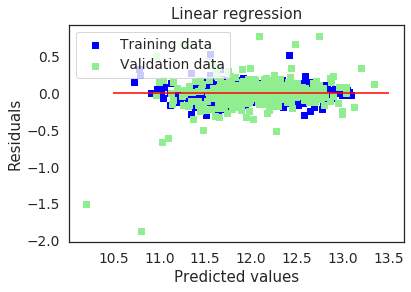

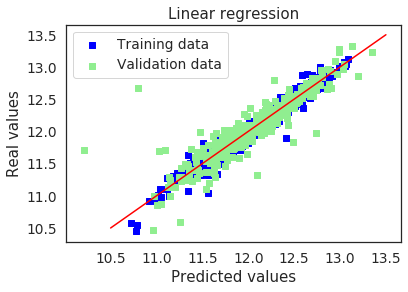

In [12]:
# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")

In [13]:
cv5_accuracy_train =  cv_rmse(lr, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(lr, X_test_preproc, y_test, cv=5)

print('CV5 train accuracies:',cv5_accuracy_train)
print('-'*75)
print('CV5 test accuracies:', cv5_accuracy_test)

model_list.append(models(name='LR',params=lr.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train accuracies: [ 1.51860899  3.40864783  0.18878537  0.19343779 14.84450932]
---------------------------------------------------------------------------
CV5 test accuracies: [ 1.43892107  0.76202841  1.43798701  4.49697417 25.75797121]


The model fits the train set well and provides reasonble train accuracy. However, it does not gneralize to the test set.
The test accuracy is very low which is also evident from the cross validation scores. This is a case of overfitting.

There are ways to mitigate overfitting and that is by using regularization.

# **Linear Regression with Ridge regularization (L2 penatly)**

In [14]:
from sklearn.linear_model import RidgeCV, Ridge

ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train_preproc, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

Best alpha : 10.0


In [15]:
ridge = Ridge(alpha=1)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9142464189040485
MSE: 0.014863543503112961
RMSE: 0.12191613307152159
--------------------------------------------------
R-sq orig price: 0.9237969941413648
MSE orig price: 522402173.01104426
RMSE orig price: 22856.118940254146


In [16]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_preproc, y_train)
y_pred = ridge.predict(X_test_preproc)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9191761622884658
MSE: 0.014009078251434631
RMSE: 0.11835995205910921
--------------------------------------------------
R-sq orig price: 0.9294796069687942
MSE orig price: 483445582.5723866
RMSE orig price: 21987.39599344103


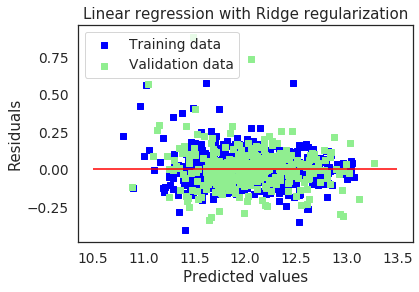

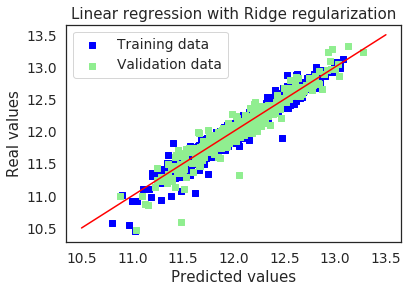

Ridge picked 416 features and eliminated the other 5 features


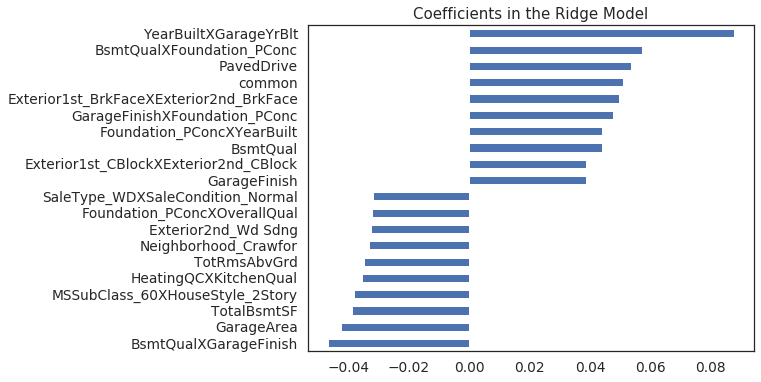

In [17]:
y_train_rdg = ridge.predict(X_train_preproc)
y_test_rdg = ridge.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Ridge Model");

In [18]:
cv5_accuracy_train =  cv_rmse(ridge, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ridge, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ridge',params=ridge.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.12171141 0.10053593 0.10637642 0.12766272 0.10995622]
---------------------------------------------------------------------------
CV5 test R-sq: [0.13049278 0.15422771 0.122302   0.14097781 0.12751551]


# **Linear Regression with Lasso regularization (L1 penalty)**

In [19]:
from sklearn.linear_model import LassoCV, Lasso

lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train_preproc, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

Best alpha : 0.0006


In [20]:
lasso = Lasso(alpha=1)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: -0.0003365656948961515
MSE: 0.17338688217957873
RMSE: 0.4163975050112317
--------------------------------------------------
R-sq orig price: -0.0404144830029356
MSE orig price: 7132458629.797031
RMSE orig price: 84453.88463414239


In [21]:
lasso = Lasso(alpha=0.0006)
lasso.fit(X_train_preproc, y_train)
y_pred = lasso.predict(X_test_preproc)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

R-sq: 0.9223008621828551
MSE: 0.013467478562875137
RMSE: 0.11604946601719086
--------------------------------------------------
R-sq orig price: 0.9346389087183173
MSE orig price: 448076499.4922447
RMSE orig price: 21167.817542019882


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4924641185032952, tolerance: 0.014647108757701699
  positive)


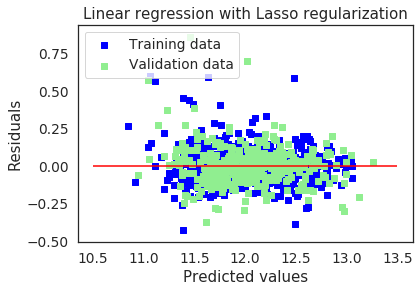

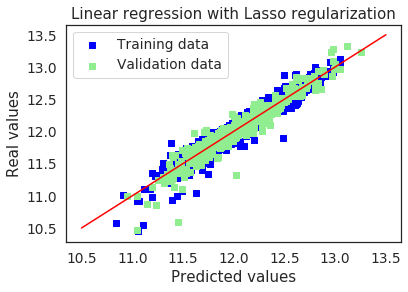

Lasso picked 136 features and eliminated the other 285 features


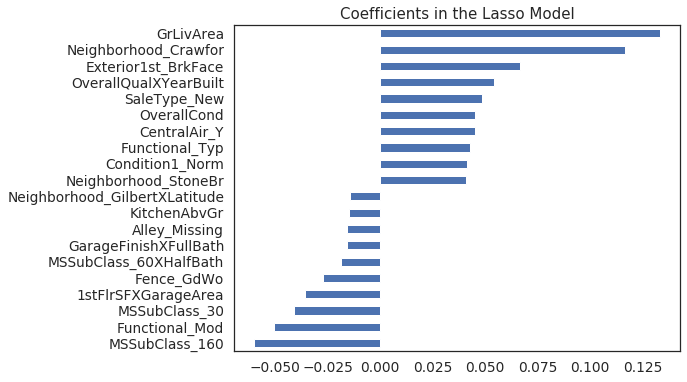

In [22]:
y_train_las = lasso.predict(X_train_preproc)
y_test_las = lasso.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train_preproc.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the Lasso Model");

In [23]:
cv5_accuracy_train =  cv_rmse(lasso, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(lasso, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='lasso',params=lasso.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22636926696224968, tolerance: 0.011686853311948011
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1745736116893255, tolerance: 0.011864433867997948
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15454612538718493, tolerance: 0.011840654302834387
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might wa

CV5 train R-sq: [0.12150388 0.10301956 0.10909774 0.12539677 0.1067197 ]
---------------------------------------------------------------------------
CV5 test R-sq: [0.14035557 0.15394922 0.12458687 0.14379549 0.13425976]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05658253689645143, tolerance: 0.005767466206725459
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03366745713002395, tolerance: 0.005872537820347414
  positive)


# **Linear Regression with ElasticNet Regularization (L1 and L2 penalty)**

In [24]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV

Looks like model prefers be apply only L2 penatly

In [25]:
enet = ElasticNet(alpha=1,l1_ratio=0.5)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: -0.0003365656948961515
MSE: 0.17338688217957873
RMSE: 0.4163975050112317
--------------------------------------------------
R-sq: -0.0404144830029356
MSE: 7132458629.797031
RMSE: 84453.88463414239


In [26]:
enet = ElasticNet(l1_ratio=0,alpha=0.03)
enet.fit(X_train_preproc,y_train)
y_pred = enet.predict(X_test_preproc)

print('R-sq:', r2_score(y_test,y_pred))
print('MSE:', mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:', r2_score(y_test_exp,y_pred_exp))
print('MSE:', mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:', np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9190601707797619
MSE: 0.014029182890956142
RMSE: 0.11844485168615874
--------------------------------------------------
R-sq: 0.9315069127139944
MSE: 469547588.4615627
RMSE: 21669.046782485904


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.109068611804993, tolerance: 0.014647108757701699
  positive)


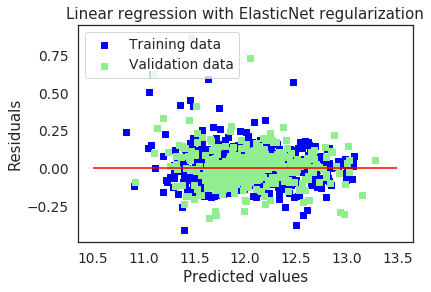

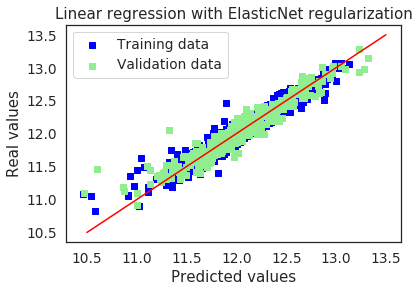

ElasticNet picked 416 features and eliminated the other 5 features


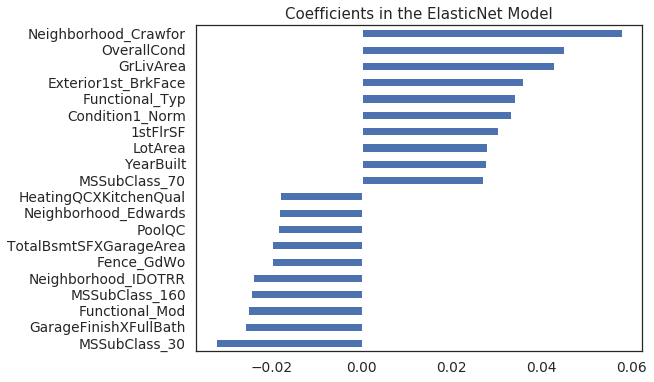

In [27]:
y_train_ela = enet.predict(X_train_preproc)
y_test_ela = enet.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(enet.coef_, index = X_train_preproc.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the ElasticNet Model");

In [28]:
cv5_accuracy_train =  cv_rmse(enet, X_train_preproc, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(enet, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ElasticNet',params=enet.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.708140149498975, tolerance: 0.011686853311948011
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.110514978641229, tolerance: 0.011864433867997948
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.113161293402449, tolerance: 0.011840654302834387
  positive)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to

CV5 train R-sq: [0.12160716 0.10070914 0.10815861 0.12664433 0.11234447]
---------------------------------------------------------------------------
CV5 test R-sq: [0.13121436 0.15454369 0.12231843 0.1417825  0.12839897]


/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5423388314967272, tolerance: 0.005872537820347414
  positive)


# **Support Vector Machine Regression**

In [29]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [30]:
svm = SVR(C=0.1, cache_size=200, coef0=1, degree=3, epsilon=0.1,
          gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
          tol=0.001, verbose=False)
svm.fit(X_train_preproc,y_train)
y_pred = svm.predict(X_test_preproc)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.9074762099140469
MSE: 0.01603701398168642
RMSE: 0.12663733249593667
--------------------------------------------------
R-sq: 0.9175729286249705
MSE: 565070638.8293
RMSE: 23771.21450051091


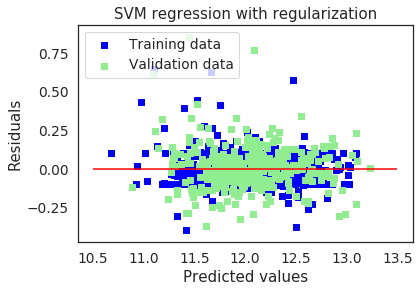

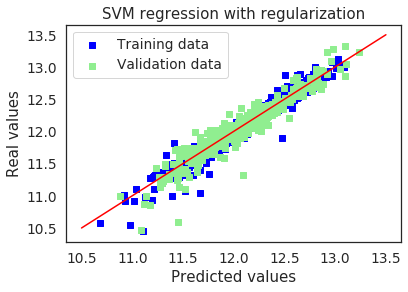

SVR picked up 403 features and eliminated 18 features


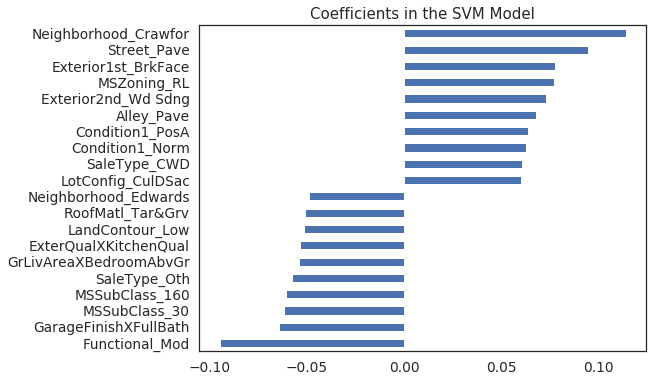

In [31]:
y_train_svm = svm.predict(X_train_preproc)
y_test_svm = svm.predict(X_test_preproc)

# Plot residuals
plt.scatter(y_train_svm, y_train_svm - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test_svm - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_svm, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_svm, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("SVM regression with regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(np.squeeze(svm.coef_) , index = X_train_preproc.columns)
print("SVR picked up " + str(sum(coefs != 0)) + " features and eliminated " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh",figsize=(8,6))
plt.title("Coefficients in the SVM Model");

In [32]:
cv5_accuracy_train =  cv_rmse(svm, X_train_preproc, y_train, cv=5)
cv5_accuracy_test = cv_rmse(svm, X_test_preproc, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='svm',params=svm.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.13177341 0.11348943 0.11205691 0.14436452 0.10960073]
---------------------------------------------------------------------------
CV5 test R-sq: [0.1420952  0.16615641 0.13797927 0.16280428 0.14431858]


# **Random Forest**

In [33]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
%%writefile random_forest.py

#!/usr/bin/env python
#SBATCH -t 5-30:30:30
#SBATCH --cores-per-socket=4
#SBATCH --sockets-per-node=2
#SBATCH --nodes=2-4
#SBATCH --mem=24000
#SBATCH -J rf
#SBATCH -o rf.out


import pandas as pd
import numpy as np
import pickle

with open('processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators':[50,100,150,200,250,300,350,400],
    'max_depth':[2,5,10,15,20,25,50,75,100],
    'min_samples_split':[4,8,10,15,20,25,30],
    'min_samples_leaf':[1,3,6,8,10,12,15],
}

rf_cv = GridSearchCV(RandomForestRegressor(),param_grid=param_grid,n_jobs=-1,cv=10)
rf_cv.fit(X_train,y_train)

with open('rf_mod.pkl','wb') as out:
    pickle.dump(rf_cv,out)

Overwriting random_forest.py


In [34]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8966193642325943
MSE: 0.017918815254945125
RMSE: 0.13386117904360892
--------------------------------------------------
R-sq: 0.8984931469265002
MSE: 695870195.9799421
RMSE: 26379.351697491395


In [35]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

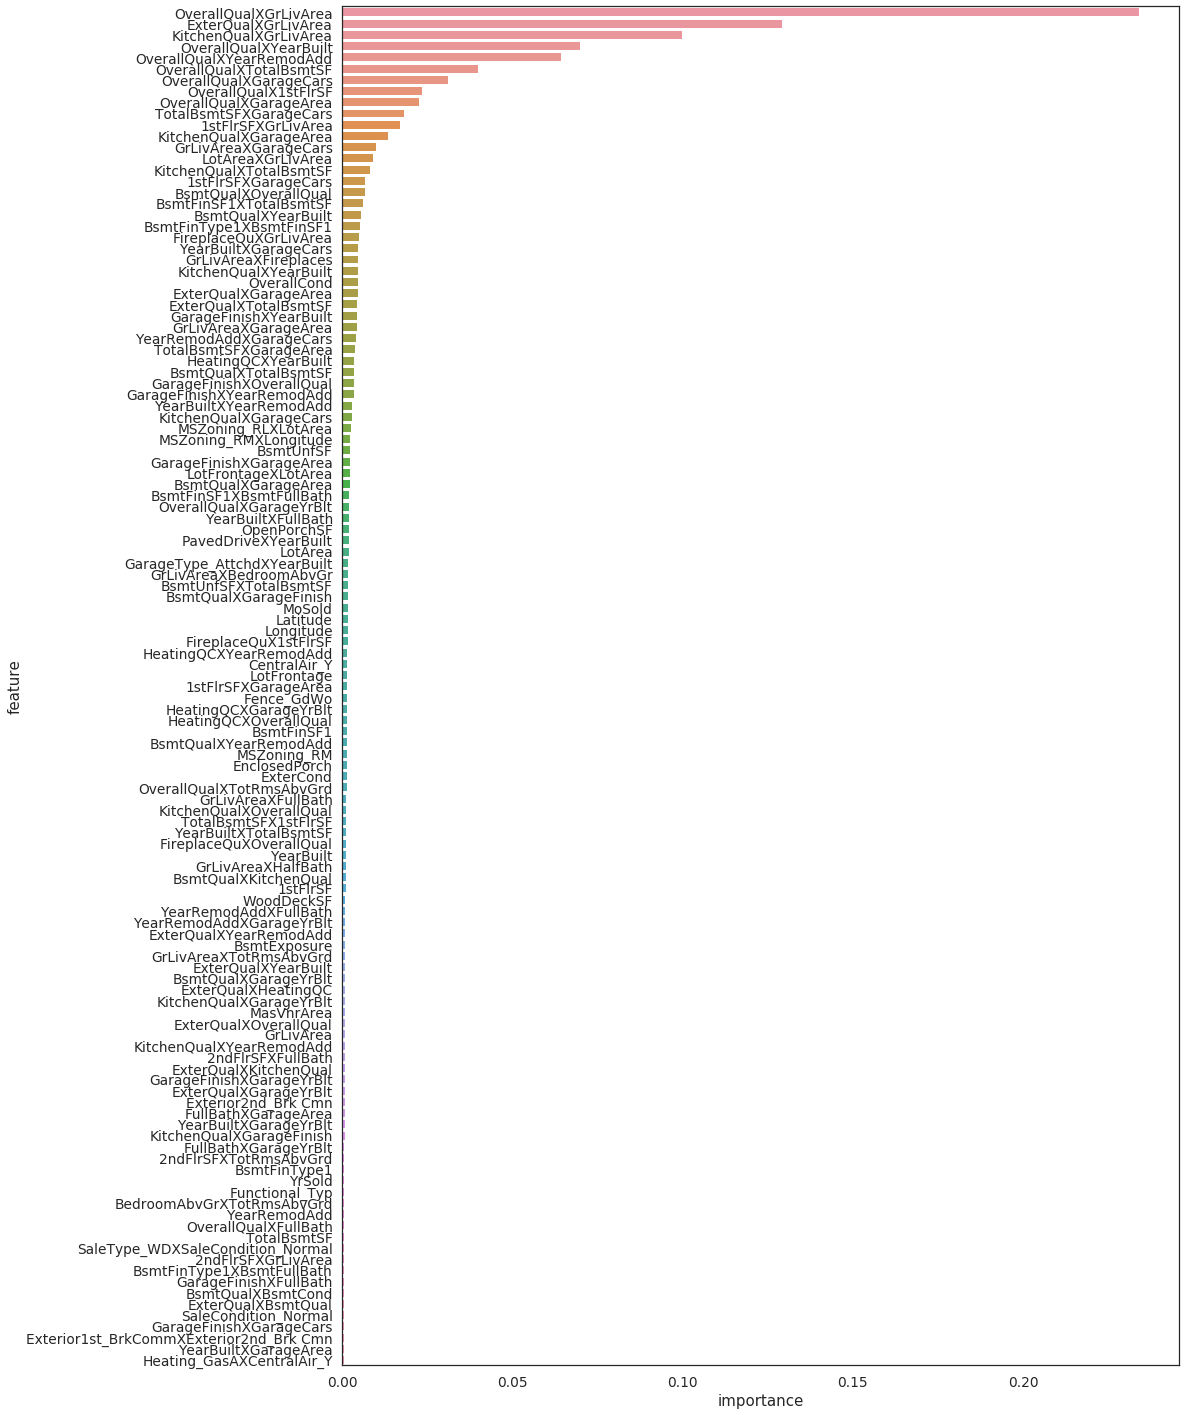

In [36]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [37]:
with open('rf_mod.pkl','rb') as rf_mod_file:
    rf_cv = pickle.load(rf_mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [38]:
rf_cv.best_params_

{'max_depth': 75,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 200}

In [39]:
rf = RandomForestRegressor(n_estimators=200,
                           max_depth=75,
                           min_samples_leaf=3,
                           min_samples_split=4)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.895531091762384
MSE: 0.01810744393957244
RMSE: 0.13456390281042105
--------------------------------------------------
R-sq: 0.8971236252230332
MSE: 705258816.6231242
RMSE: 26556.7094464492


In [40]:
feature_importance = pd.DataFrame(np.round(rf.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace =True)

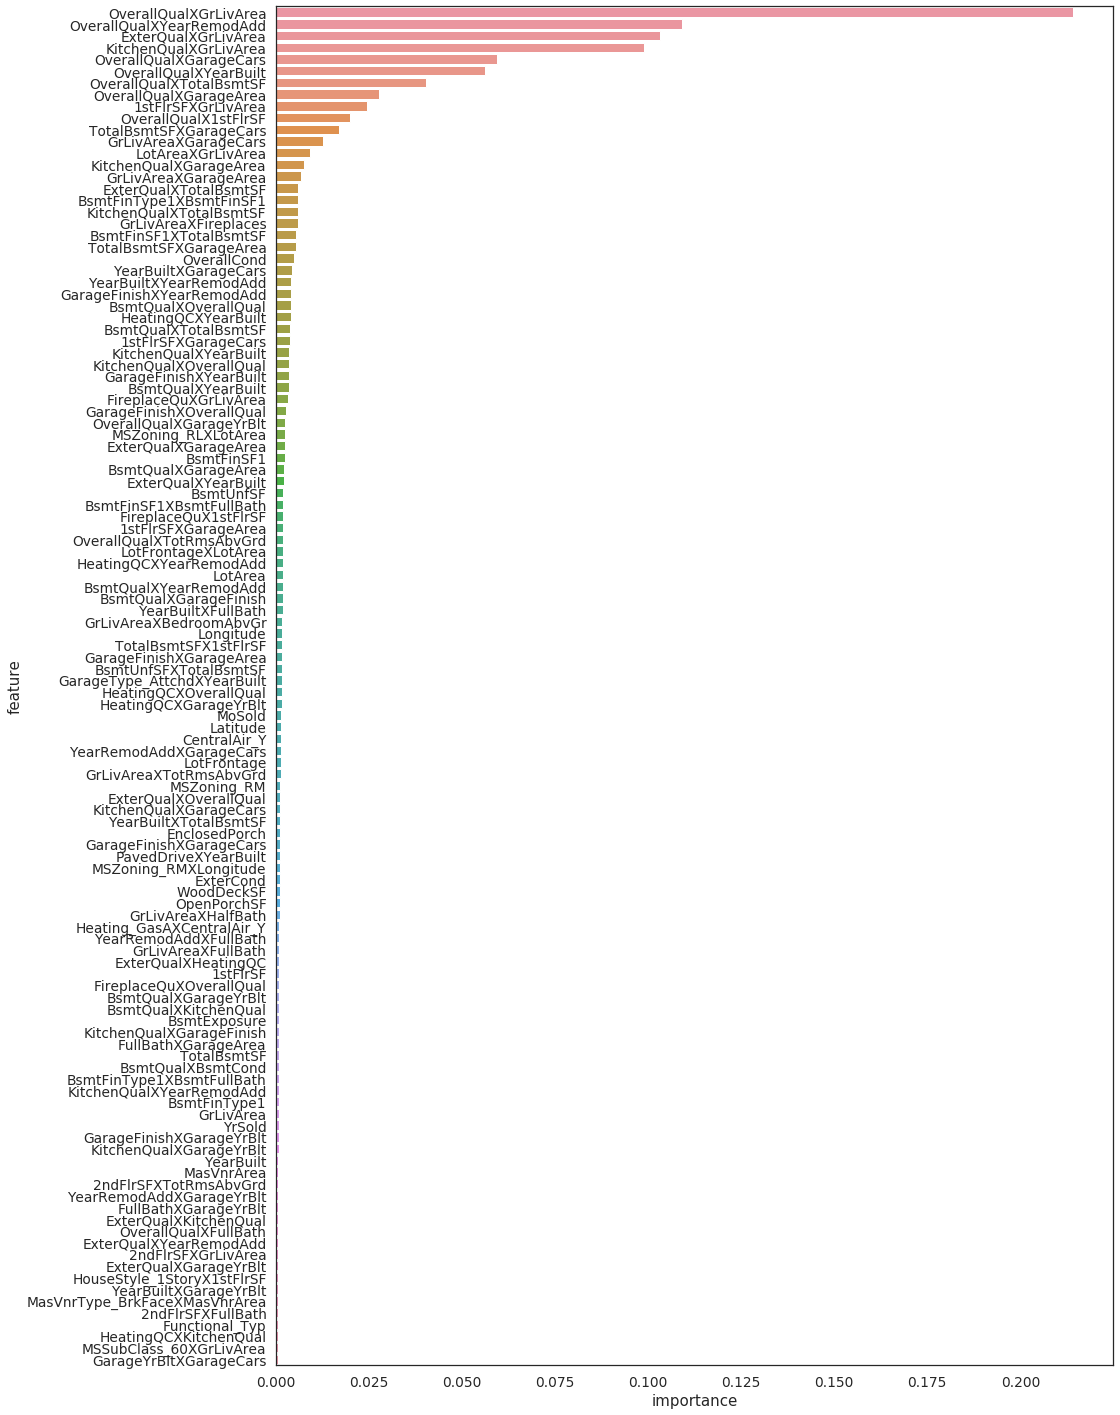

In [41]:
plt.figure(figsize=(15,25))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [42]:
cv5_accuracy_train = cv_rmse(rf, X_train, y_train, cv=5)
cv5_accuracy_test = cv_rmse(rf, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='rf',params=rf.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.13092297 0.12622195 0.1235818  0.15047774 0.12585423]
---------------------------------------------------------------------------
CV5 test R-sq: [0.11430106 0.16967713 0.11901528 0.14965174 0.1258689 ]


# **AdaBoost Regression**

In [43]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

In [44]:
ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=75,
                                                             min_samples_leaf=3,
                                                             min_samples_split= 4),
                       n_estimators=200,learning_rate=0.5,random_state=42)

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8949004860845389
MSE: 0.01821674590464691
RMSE: 0.1349694258143188
--------------------------------------------------
R-sq: 0.9072431551094154
MSE: 635885379.9334587
RMSE: 25216.767832802416


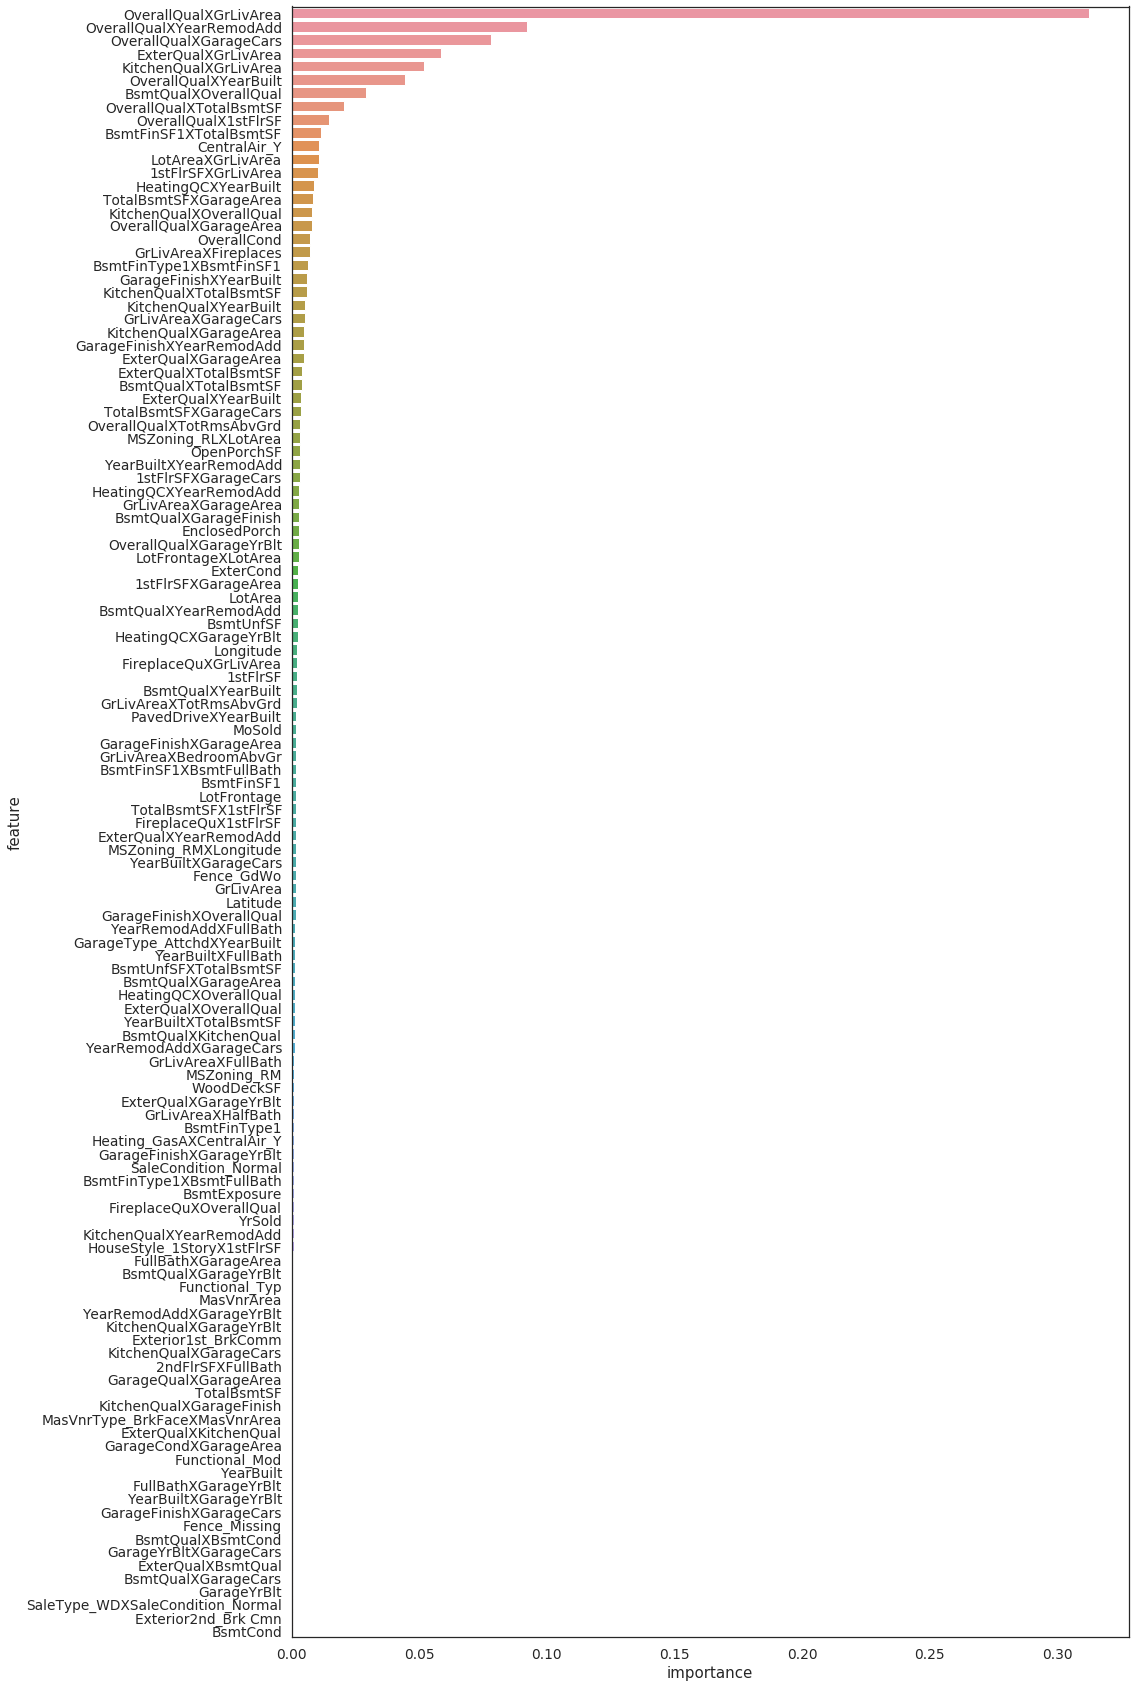

In [45]:
feature_importance = pd.DataFrame(np.round(ada.feature_importances_,decimals=4),
                                  index=X_train.columns,columns=['importance']).sort_values(by='importance',
                                                                                            ascending=False)
feature_importance.index.name = 'feature'
feature_importance.reset_index(inplace = True)

plt.figure(figsize=(15,30))
sns.barplot(y='feature',x='importance',data=feature_importance[feature_importance['importance']>0.0003],orient='h')

In [46]:
%%writefile AdaBoost_cv.py
#!/usr/bin/env python
#SBATCH -t 5-30:30:30
#SBATCH --cores-per-socket=4
#SBATCH --sockets-per-node=2
#SBATCH --nodes=2-4
#SBATCH --mem=24000
#SBATCH -J python
#SBATCH -o adaBoost.out


import pandas as pd
import numpy as np
import pickle

with open('processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

param_grid_tree = {
    'max_depth':[None,2,5,10,15,20,25,50,75,100],
    'min_samples_split':[2,4,8,10,15,20,25,30],
    'min_samples_leaf':[2,4,6,8,10,12,15,30],
}
tree = DecisionTreeRegressor()
tree_cv = GridSearchCV(tree,param_grid=param_grid_tree,n_jobs=-1,cv=10)
tree_cv.fit(X_train,y_train)

base_estimator = tree_cv.best_estimator_

param_grid_ada = {
    'n_estimators':[50,100,150,200,250,300,350,400],
    'learning_rate' : [0.01, 0.05, 0.1, 0.5],
    'loss' : ['linear', 'square', 'exponential'],
}

ada = AdaBoostRegressor(base_estimator=base_estimator)
ada_cv = GridSearchCV(ada,param_grid=param_grid_ada,cv=10,n_jobs=-1)
ada_cv.fit(X_train,y_train)

with open('ada_mod.pkl','wb') as out:
    pickle.dump(ada_cv,out)

Overwriting AdaBoost_cv.py


In [46]:
with open('ada_mod.pkl','rb') as mod_file:
    ada_cv = pickle.load(mod_file)

/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator AdaBoostRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/climbach/anaconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [47]:
ada_cv.best_params_

{'learning_rate': 0.5, 'loss': 'square', 'n_estimators': 400}

In [48]:
ada = ada_cv.best_estimator_
ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('R-sq:',r2_score(y_test,y_pred))
print('MSE:',mean_squared_error(y_test,y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_pred)))
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq:',r2_score(y_test_exp,y_pred_exp))
print('MSE:',mean_squared_error(y_test_exp,y_pred_exp))
print('RMSE:',np.sqrt(mean_squared_error(y_test_exp,y_pred_exp)))

R-sq: 0.8961723944886664
MSE: 0.01799628787064864
RMSE: 0.13415024364736963
--------------------------------------------------
R-sq: 0.9043654280271556
MSE: 655613353.4453449
RMSE: 25604.94783133418


In [49]:
cv5_accuracy_train =  cv_rmse(ada, X_train, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(ada, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='ada',params=ada.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.12570533 0.12723163 0.12195791 0.14716229 0.12544404]
---------------------------------------------------------------------------
CV5 test R-sq: [0.124128   0.15561371 0.11864727 0.1603009  0.132639  ]


# **Gradient Boost**

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

In [51]:
gbrt = GradientBoostingRegressor()
gbrt.fit(X_train,y_train)
y_pred = gbrt.predict(X_test)

print('Test accuracies:')
print('-'*50)
print('R-sq:', r2_score(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)
print('-'*50)
print('R-sq orig price:', r2_score(y_test_exp, y_pred_exp))
print('MSE orig price:', mean_squared_error(y_test_exp, y_pred_exp))
print('RMSE orig price:', np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)))

Test accuracies:
--------------------------------------------------
R-sq: 0.9078263941872597
MSE: 0.01597631705087042
RMSE: 0.12639745666298202
--------------------------------------------------
R-sq orig price: 0.900962844818707
MSE orig price: 678939426.241501
RMSE orig price: 26056.46611191742


In [52]:
cv5_accuracy_train =  cv_rmse(gbrt, X_train, y_train, cv=5)
cv5_accuracy_test =  cv_rmse(gbrt, X_test, y_test, cv=5)

print('CV5 train R-sq:',cv5_accuracy_train)
print('-'*75)
print('CV5 test R-sq:', cv5_accuracy_test)

model_list.append(models(name='gbrt',params=gbrt.get_params(),
                         cv5_mean_accuracy_train = np.mean(cv5_accuracy_train),
                         cv5_std_accuracy_train=np.std(cv5_accuracy_train),
                         cv5_mean_accuracy_test=np.mean(cv5_accuracy_test),
                         cv5_std_accuracy_test=np.std(cv5_accuracy_test)))

CV5 train R-sq: [0.1302491  0.12372115 0.11719924 0.13811983 0.11846915]
---------------------------------------------------------------------------
CV5 test R-sq: [0.1230937  0.16507406 0.10742728 0.13573501 0.12443691]


In [56]:
%%writefile gbrt_cv.py
#!/usr/bin/env python
#SBATCH -t 5-30:30:30
#SBATCH --cores-per-socket=4
#SBATCH --sockets-per-node=2
#SBATCH --nodes=2-4
#SBATCH --mem=24000
#SBATCH -J python
#SBATCH -o gbrt_cv.out

import pandas as pd
import numpy as np
import pickle

with open('processed_data.pkl','rb') as file:
    FEATURES, ordinal_map, interactions, train, y = pickle.load(file)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=42)

print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid_gbrt = {
    'loss' : ['ls','lad','huber','quantile'],
    'learning_rate' : [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
    'n_estimators':[50,100,150,200,250,300,350,400],
    'min_samples_split':[2,4,8,10,15,20,25,30],
    'min_samples_leaf':[2,4,6,8,10,12,15,30],
    'max_depth':[None,2,5,10,15,20,25,50,75,100],
}

gbrt = GradientBoostingRegressor()
gbrt_cv = GridSearchCV(gbrt,param_grid=param_grid_gbrt,cv=10,n_jobs=-1)
gbrt_cv.fit(X_train,y_train)

with open('gbrt_mod.pkl','wb') as out:
    pickle.dump(gbrt_cv,out)

Overwriting gbrt_cv.py


In [53]:
mod_table = pd.DataFrame()
for model in model_list:
    tmp_df = pd.DataFrame([model.name,
                           model.cv5_mean_accuracy_train,
                           model.cv5_std_accuracy_train,
                           model.cv5_mean_accuracy_test,
                           model.cv5_std_accuracy_test],
                          index=['model',
                                   'train_mean_ac',
                                   'train_std_ac',
                                   'test_mean_ac',
                                   'test_std_ac']).T
    
    mod_table = pd.concat([mod_table,tmp_df],axis=0)
    
mod_table.reset_index(drop=True,inplace=True)

In [54]:
for col in mod_table.columns:
    if col != 'model':
        mod_table[col]= mod_table[col].astype(float)

In [55]:
mod_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 5 columns):
model            8 non-null object
train_mean_ac    8 non-null float64
train_std_ac     8 non-null float64
test_mean_ac     8 non-null float64
test_std_ac      8 non-null float64
dtypes: float64(4), object(1)
memory usage: 400.0+ bytes


Text(0.5, 1.0, 'Train vs. Test RMSE')

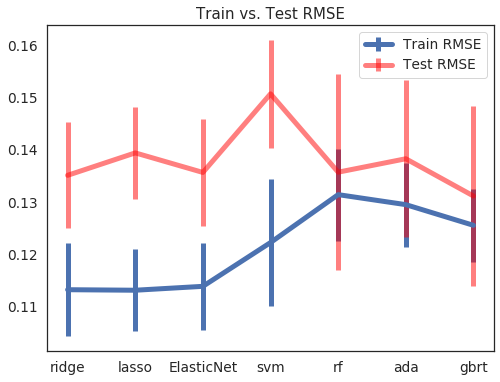

In [56]:
train_errorbar_width_array = (mod_table.loc[1:,'train_std_ac']/np.sqrt(5))*2

plt.figure(figsize =(8,6))
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'train_mean_ac'],
             yerr=train_errorbar_width_array,
             label='Train RMSE',
             linewidth=5)

test_errorbar_width_array = (mod_table.loc[1:,'test_std_ac']/np.sqrt(5))*2
plt.errorbar(x=mod_table.loc[1:,'model'],
             y=mod_table.loc[1:,'test_mean_ac'],
             yerr=test_errorbar_width_array,
             label='Test RMSE',
             linewidth=5,
             color='red',
             alpha =0.5)
plt.legend()
plt.title('Train vs. Test RMSE')

In [57]:
mod_table.sort_values(by=['test_mean_ac','test_std_ac'],ascending=[True,True])

,model,train_mean_ac,train_std_ac,test_mean_ac,test_std_ac
7,gbrt,0.125552,0.007788,0.131153,0.019207
1,ridge,0.113249,0.009991,0.135103,0.011340
3,ElasticNet,0.113893,0.009287,0.135652,0.011354
5,rf,0.131412,0.009827,0.135703,0.020890
6,ada,0.129500,0.008998,0.138266,0.016751
2,lasso,0.113148,0.008720,0.139389,0.009775
4,svm,0.122257,0.013568,0.150671,0.011506
0,LR,4.030798,5.533912,6.778776,9.577639
